<a href="https://colab.research.google.com/github/MatthewK84/MBA-8660/blob/main/MBA_8660_Project_2_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ok Cupid Dataset EDA

The dataset was selected as it is somewhat entertaining. Additionally, it serves as a good practice arena for lambda functions and other data manipulation techniques to hone in on a useable subset.

## Prepare for Data Analysis

### Load Packages

In [8]:
# initial imports and check file is readable
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image # linked to generating a wordcloud
from os import path # for wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator # for wordcloud

import re #regular expressions
import nltk
nltk.download('stopwords')
from nltk.tokenize import word_tokenize #turn strings into lists
from nltk.corpus import stopwords # remove words like 'a', 'an' etc.
stop_words = set(stopwords.words('english')) #imports the english stopwords
from nltk.stem import PorterStemmer #for 'stemming' words to improve search/assessments
stemmer = PorterStemmer()

okcupid = pd.read_csv('okcupid_profiles.csv')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
import warnings
warnings.filterwarnings("ignore")

### Load Data

In [10]:
print("There are {} observations (i.e. personal profiles) and {} features in this dataset. \n".format(okcupid.shape[0],okcupid.shape[1]))

There are 59947 observations (i.e. personal profiles) and 154 features in this dataset. 



## Data Exploration

### Duplicates check

In [11]:
duplicates = okcupid.duplicated()
print(duplicates.value_counts())

False    59947
dtype: int64


The number of false duplicates equals the number of rows - i.e. there are no dupicated rows

## Tidying/Wrangling

In [12]:
okcupid_variables = pd.DataFrame(okcupid.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59947 entries, 0 to 59946
Columns: 154 entries, age to Unnamed: 153
dtypes: object(154)
memory usage: 70.4+ MB


This dataset seems mostly/totally complete in the primary areas needed for a dating profile:

_Complete_
* Age
* Status (relationship status)
* Sex
* Orentation
* Last online (missing values here would be due to technical error - no online presence, no profile, no entry)
* Location
* Income

_Mostly complete (<5% missing values/ over 532000 values)_
* Body type
* Drinks (consumes alcohol)
* Education
* Ethnicity
* Height
* Smokes
* Speaks (languages)
* Essay 0 (first freeform question)

This gives a glimpse into which variables are possibly most valued, because either they were set as compulsory or people decided to complete them

In [13]:
print(okcupid.columns)

Index(['age', 'status', 'sex', 'orientation', 'body_type', 'diet', 'drinks',
       'drugs', 'education', 'ethnicity',
       ...
       'Unnamed: 144', 'Unnamed: 145', 'Unnamed: 146', 'Unnamed: 147',
       'Unnamed: 148', 'Unnamed: 149', 'Unnamed: 150', 'Unnamed: 151',
       'Unnamed: 152', 'Unnamed: 153'],
      dtype='object', length=154)


Next I'll inspect each variable

In [14]:
okcupid.age.describe()

count     59947
unique      107
top          26
freq       3490
Name: age, dtype: int64

'Age'

A complete variable, so next is to check the quality of the data. The min value is reasonable at 18, whereas the max value is an unlikely 110

In [15]:
okcupid.age.value_counts()

26                                    3490
27                                    3451
28                                    3347
25                                    3314
29                                    3068
                                      ... 
65                                       2
69                                       2
109                                      1
110                                      1
st teachers; the powerfully humble       1
Name: age, Length: 107, dtype: int64

In [16]:
# Define a function to safely convert strings to integers
def safe_int_conversion(value):
    try:
        return int(value)
    except ValueError:
        return None  # or return a placeholder like -1 or np.nan

# Apply the function to the 'age' column
okcupid['age'] = okcupid['age'].apply(safe_int_conversion)

--> a neater way to do this than value_counts()?
The data all looks reasonable apart from the ages of 110 and 109 - likely someone incorrectly entered their birthday or used a fake one

In [17]:
age_errors = okcupid[okcupid.age > 100]

From viewing these, it seems where age=110 the profile may have been speculative and not wanting to give much information, as there is very little other information.
Where age=109, there may have been an error as he is also uncommonly tall, 242 cm (shortest male entrant in list of Wikipedia world's tallest people is 216cm )

Will consider what to do with these results when the aim of the investigation is clearer

In [18]:
okcupid.status.value_counts()

single                                                                                                        55697
seeing someone                                                                                                 2064
available                                                                                                      1865
married                                                                                                         310
unknown                                                                                                          10
simple and potent people met in everyday life ... (which especially includes infants and children) athlete        1
Name: status, dtype: int64

'Status'

is Relationship Status.
Categories are:
* Single
* Seeing somone
* Available
* Married
* Unknown - this one needs further investigation: unknown as in profile hasn't added their status? (from code snippet below I'd say yes)

In [19]:
okcupid.sex.value_counts()

m                                                       35829
f                                                       24117
 strength trainer/power lifter with brains and heart        1
Name: sex, dtype: int64

'Sex'

Only in two vales: 'm' or 'f'

In [20]:
okcupid.orientation.value_counts()

straight                                       51606
gay                                             5573
bisexual                                        2767
 easy on the eyes.  i'm looking for friends        1
Name: orientation, dtype: int64

'Orientation'

is 'straight', 'gay' and 'bisexual'
Seen here large majority is straight, followed by gay then bisexual

In [21]:
okcupid.body_type.value_counts()

average           14652
fit               12711
athletic          11819
thin               4711
curvy              3924
a little extra     2629
skinny             1777
full figured       1009
overweight          444
jacked              421
used up             355
rather not say      198
 community            1
Name: body_type, dtype: int64

In [22]:
null_bodies = okcupid[okcupid.body_type.isnull()]

'Body_type'

average           14652,
fit               12711,
athletic          11819,
thin               4711,
curvy              3924,
a little extra     2629,
skinny             1777,
full figured       1009,
overweight          444,
jacked              421,
used up             355,
rather not say      198
From here I'll assume the NaN values are just unfilled cells


In [23]:
okcupid.diet.value_counts()

mostly anything        16585
anything                6183
strictly anything       5113
mostly vegetarian       3444
mostly other            1007
strictly vegetarian      875
vegetarian               667
strictly other           452
mostly vegan             338
other                    331
strictly vegan           228
vegan                    136
mostly kosher             86
mostly halal              48
strictly halal            18
strictly kosher           18
halal                     11
kosher                    11
 dating partner(s)         1
Name: diet, dtype: int64

In [24]:
food_df = okcupid[okcupid['diet'].isin(["mostly anything", "strictly anything", "mostly vegetarian", "strictly vegetarian"])]

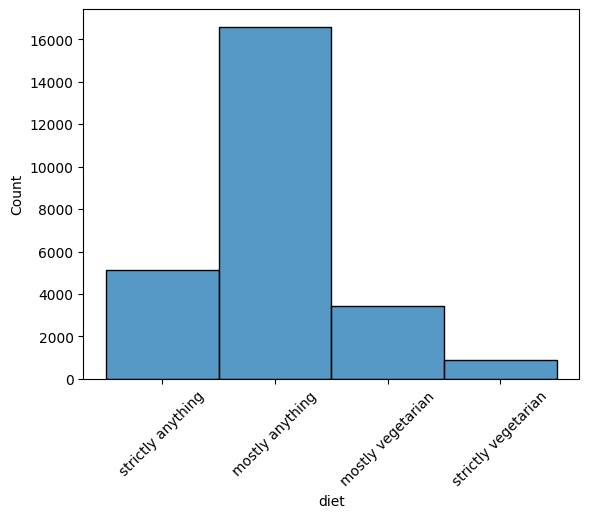

In [25]:
sns.histplot(x='diet', data=food_df)
plt.xticks(rotation=45)
plt.show()

'Diet'

Variety of diet types, expaned by some having 'mostly...' and 'strictly...' categories

'Drinks'

In [26]:
okcupid.drinks.value_counts()

socially       41780
rarely          5957
often           5164
not at all      3267
very often       471
desperately      322
 playmates         1
Name: drinks, dtype: int64

'Drugs'

In [27]:
okcupid.drugs.value_counts()

never                       37724
sometimes                    7732
often                         410
 and maybe down the line        1
Name: drugs, dtype: int64

In [28]:
okcupid.education.value_counts()

graduated from college/university            23959
graduated from masters program                8961
working on college/university                 5712
working on masters program                    1683
graduated from two-year college               1531
graduated from high school                    1428
graduated from ph.d program                   1272
graduated from law school                     1122
working on two-year college                   1074
dropped out of college/university              995
working on ph.d program                        983
college/university                             801
graduated from space camp                      657
dropped out of space camp                      523
graduated from med school                      446
working on space camp                          445
working on law school                          269
two-year college                               222
working on med school                          212
dropped out of two-year college

1. Undergraduate Degree, 2. Graduate Degree, 3. Law/Medical School Graduate, 4. High School Graduate, 5.
Currently Enrolled in College Only mark your highest degree

'Education'

33 different categories, ranging from 23959 to 11 entries

In [29]:
filtered_df = okcupid[okcupid['offspring'].isin(["doesn't have kids", "has kids", 'wants kids', "doesn't want kids"])]

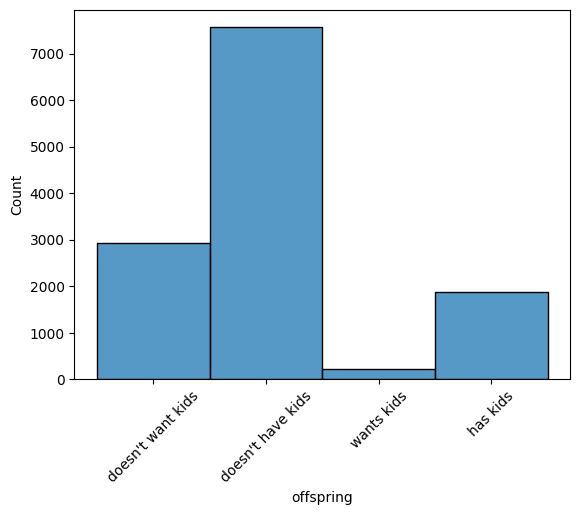

In [30]:
sns.histplot(x='offspring', data=filtered_df)
plt.xticks(rotation=45)
plt.show()

In [31]:
okcupid_mod = okcupid[okcupid['religion'].notnull()]

#Strip every word except the first
okcupid_mod['religion'] = okcupid_mod['religion'].apply(lambda x: x.split(' ')[0])

# Get value counts
value_count = okcupid_mod['religion'].value_counts()

# Filter value counts that are greater than 10
filtered_value_count = value_count[value_count > 10]

print(filtered_value_count)

agnosticism     8812
other           7743
atheism         6985
christianity    5787
catholicism     4758
judaism         3098
buddhism        1948
hinduism         450
islam            139
Name: religion, dtype: int64


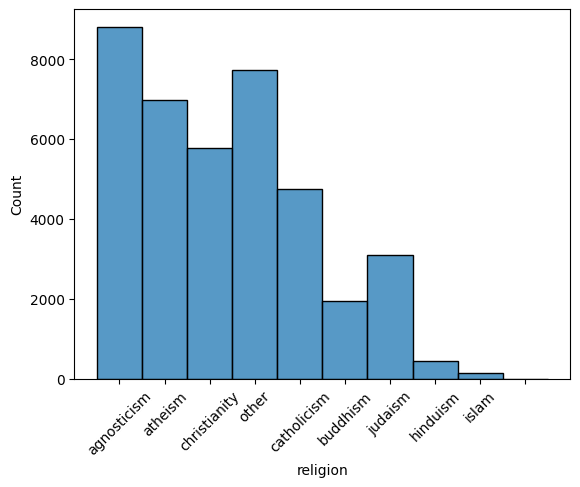

In [32]:
sns.histplot(x='religion', data=okcupid_mod)
plt.xticks(rotation=45)
plt.show()

In [33]:
okcupid_sign = okcupid[okcupid['sign'].notnull()]

okcupid_sign['sign'] = okcupid_sign['sign'].apply(lambda x: x.split(' ')[0])

# Get value counts
value = okcupid_sign['sign'].value_counts()

# Filter value counts that are greater than 10
filtered_value = value[value > 10]

# Display filtered value counts
print(filtered_value)

leo            4374
gemini         4310
libra          4207
cancer         4206
virgo          4141
taurus         4140
scorpio        4134
aries          3989
pisces         3946
sagittarius    3942
aquarius       3928
capricorn      3573
Name: sign, dtype: int64


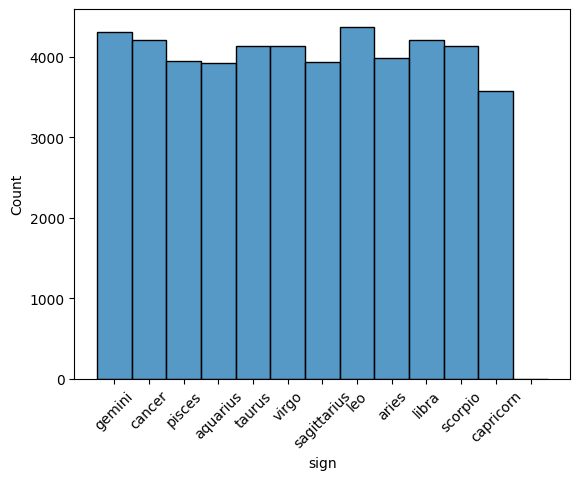

In [34]:
sns.histplot(x='sign', data=okcupid_sign)
plt.xticks(rotation=45)
plt.show()

# The essays
Each profile has 'essays' - free form answer questions.
This section looks to be suited to a language focused analysis, enabling answering questions such as:
* which words are most frequently used
* which topics most frenquently arise

Explore sorting and filtering words and create a word cloud for to display frequencies

In [35]:
from nltk import TweetTokenizer #TweetTokenizer was tried so solve another problem
# but for the context it may be more applicable than word_tokenize()
tokens_main = []
for col in okcupid.filter(regex="essay\d+", axis=1).columns: #regex="essay\d+" tells to apply to cols with this title, \d+ is a digit +1
    okcupid[col] = okcupid[col].str.replace("[.?!,:;()\-\"]", "", regex=True)
    tokens = nltk.TweetTokenizer().tokenize(str(okcupid[col])) # I'd like to understand what okcupid[col] is withouth str() and why str() is needed
    tokens_no_stops = [word for word in tokens if word not in stop_words]
    tokens_no_stops = [word for word in tokens_no_stops if word not in ['NaN', '...', 'im']]
    tokens_main += tokens_no_stops #this may be an issue - better try tokens_main.append(tokens_no_stops)
    print(len(tokens_main))

72
145
218
279
357
424
469
525
583
635


In [36]:
# generate a dictionary with the key being the word and the value being the frequency of the word
tokens_dict = {}
for word in tokens_main:
    if word in tokens_dict:
        tokens_dict[word] = tokens_dict[word]+1
    else:
        tokens_dict[word]=1

#print(tokens_dict)
#print(len(tokens_dict))